In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

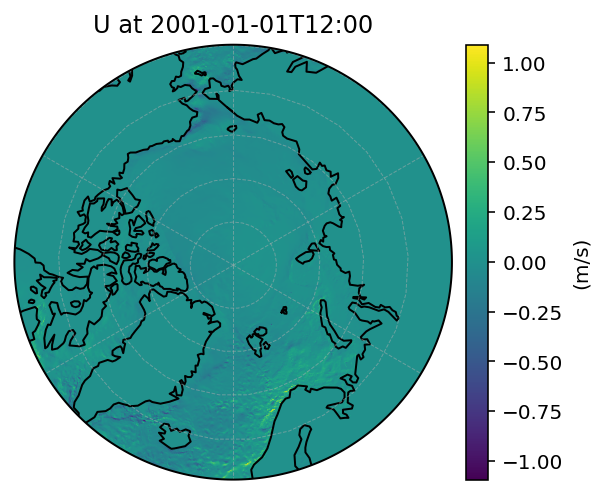

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [5]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [9]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

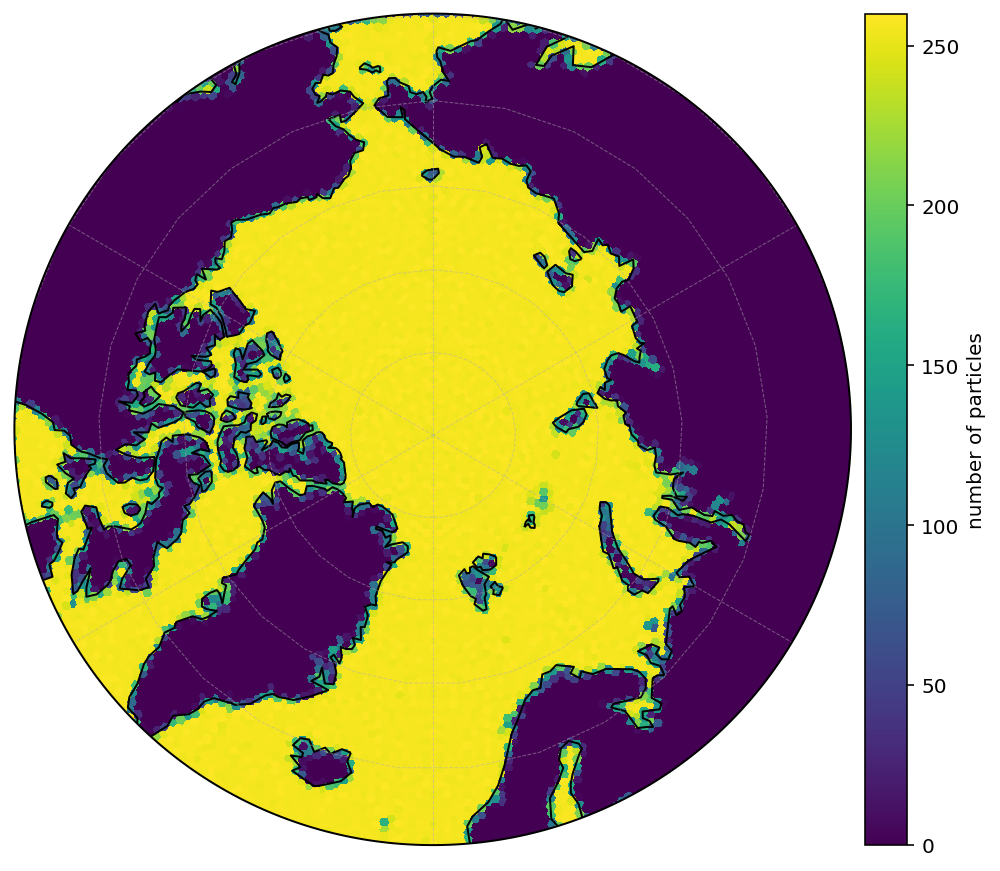

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

## March 2018

In [7]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

In [ ]:
transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(30, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

In [8]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [ ]:
comName = runName + "_Cico7_subD30_mt2"

In [ ]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

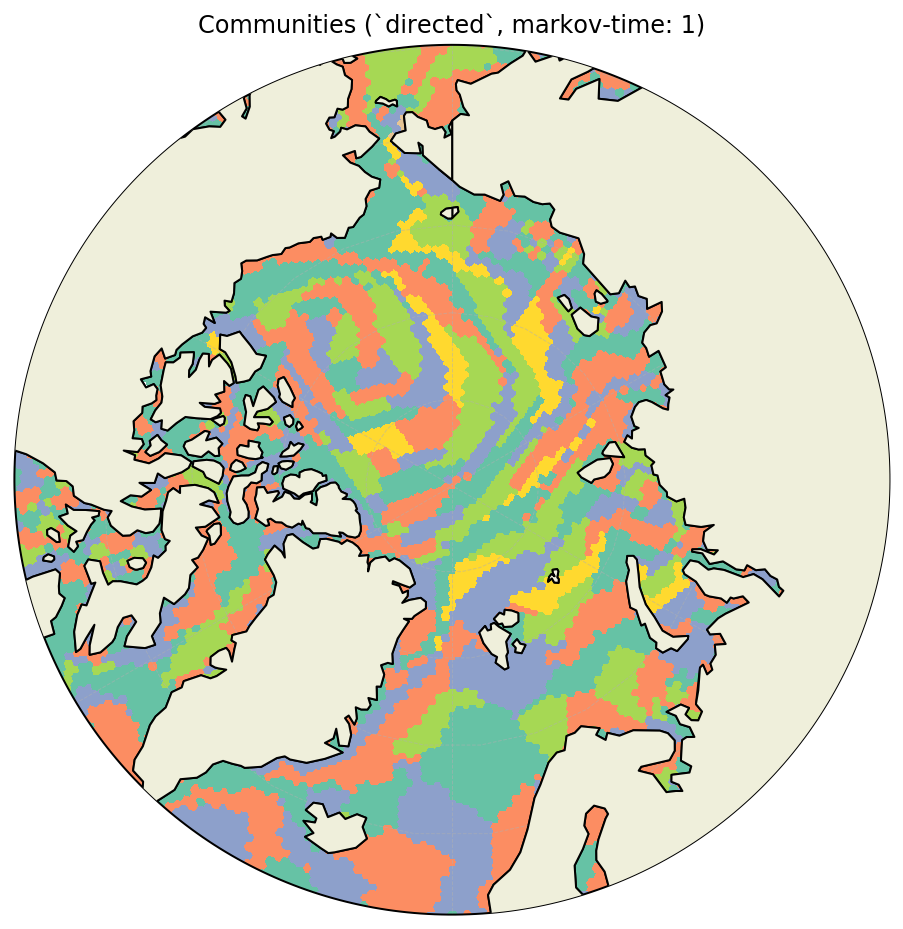

In [34]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (`directed`, markov-time: 1)"
                                            )

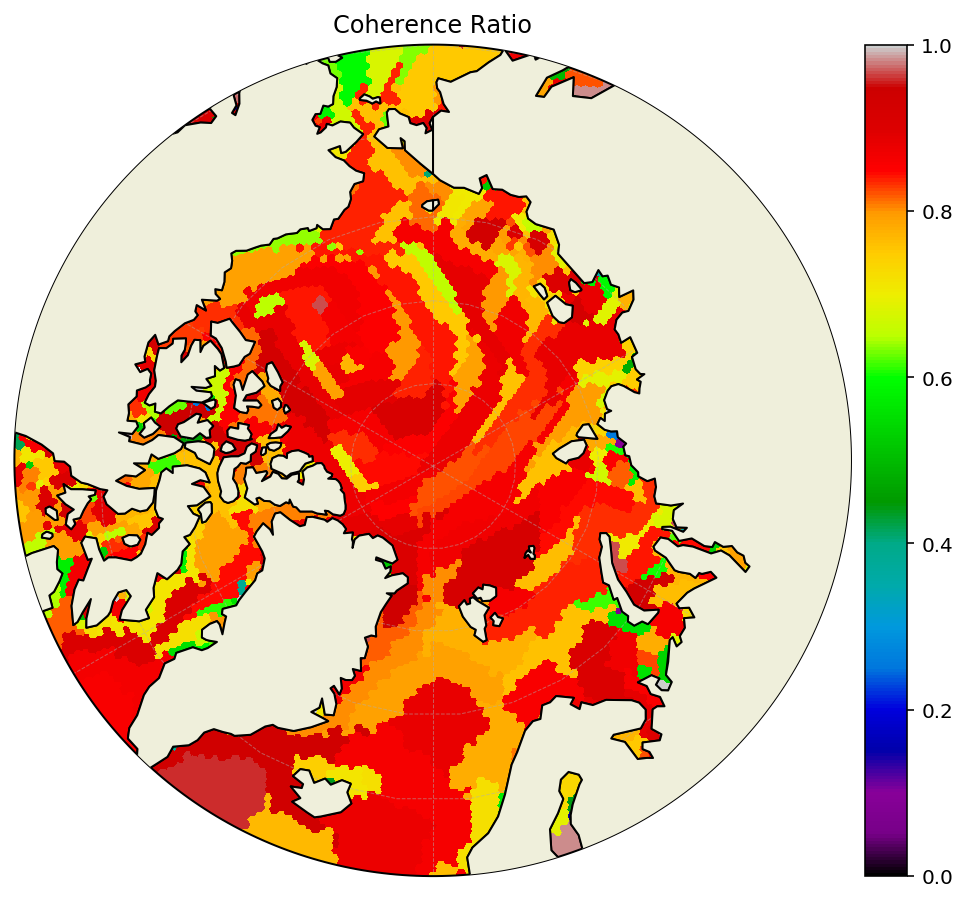

In [40]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

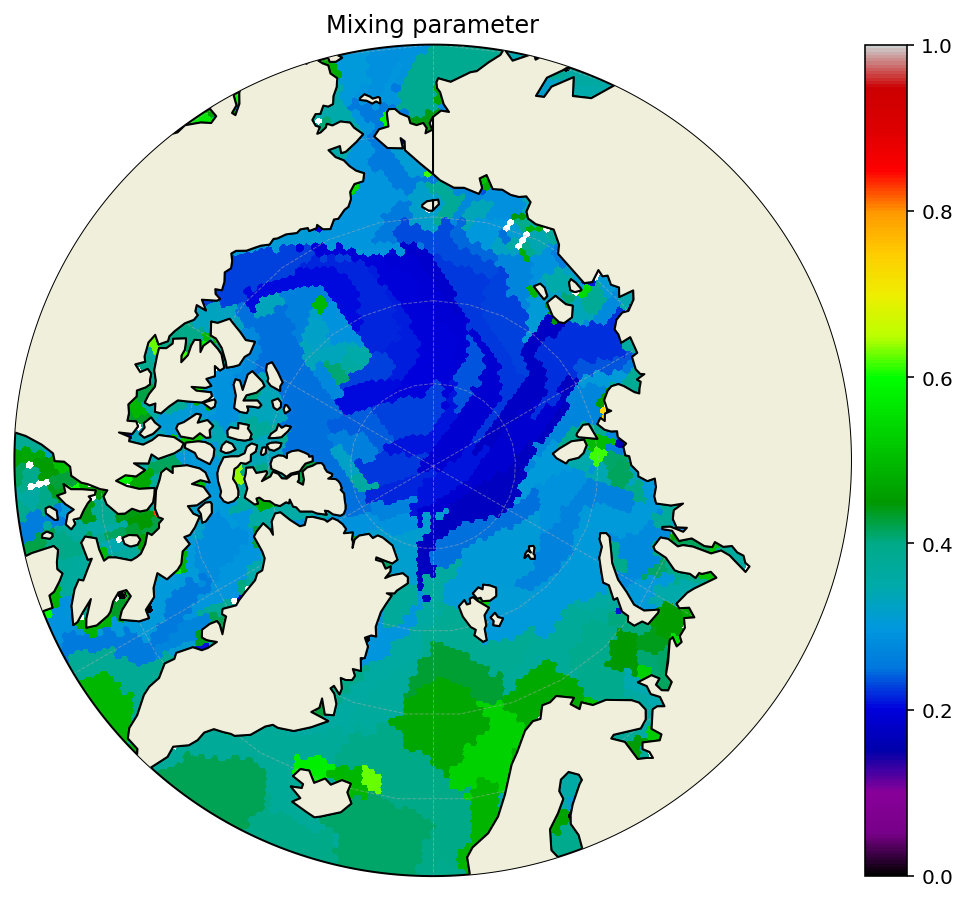

In [41]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )

# Boundary current transitions

In [9]:
def transitionProbabilityPoint(transmat, lon, lat):
    pointIndex = np.searchsorted(myBins.bindex[myBins.oceanMask], myBins.pointToIdx(lon, lat))
    pointData = transmat[pointIndex][0]
    dataInBins = np.full(myBins.bindex.shape, np.nan)
    dataInBins[myBins.bindex[myBins.oceanMask]] = pointData
    dataInBins = np.where(dataInBins==0, np.nan, dataInBins)
    fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                                 myBins.svTriLats, 
                                                 myBins.svSimplices[myBins.svDomainMask], 
                                                 dataInBins[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                                lonRange = (-50, 30),
                                                latRange = (60, 90),
                                                land = True,
                                                size = (8,8),
                                                cbar = True,
                                                colormap = 'gist_ncar',
                                                polar = False,
                                                wedge = True,
                                                vmin = 0,
                                                vmax = 1,
                                                units = "Transition probability"
                                                )
    ax.scatter([lon], [lat], marker='*', s=50, c='white', transform=ccrs.PlateCarree())
    plt.show()
    return dataInBins

## MASK THE NANS BY USING A SPECIAL BINDEX-TYPE OF THING

/science/users/4302001/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


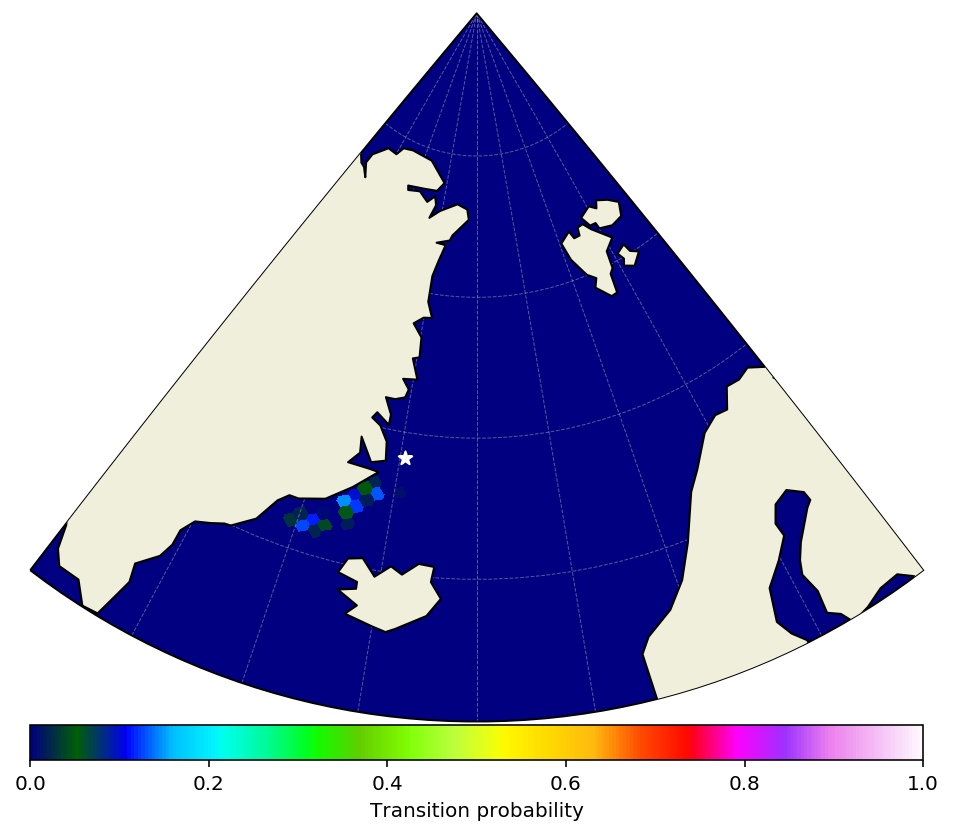

array([nan, nan, nan, ..., nan, nan, nan])

In [10]:
transitionProbabilityPoint(transMat_20180301.data, -19.3, 70.9)

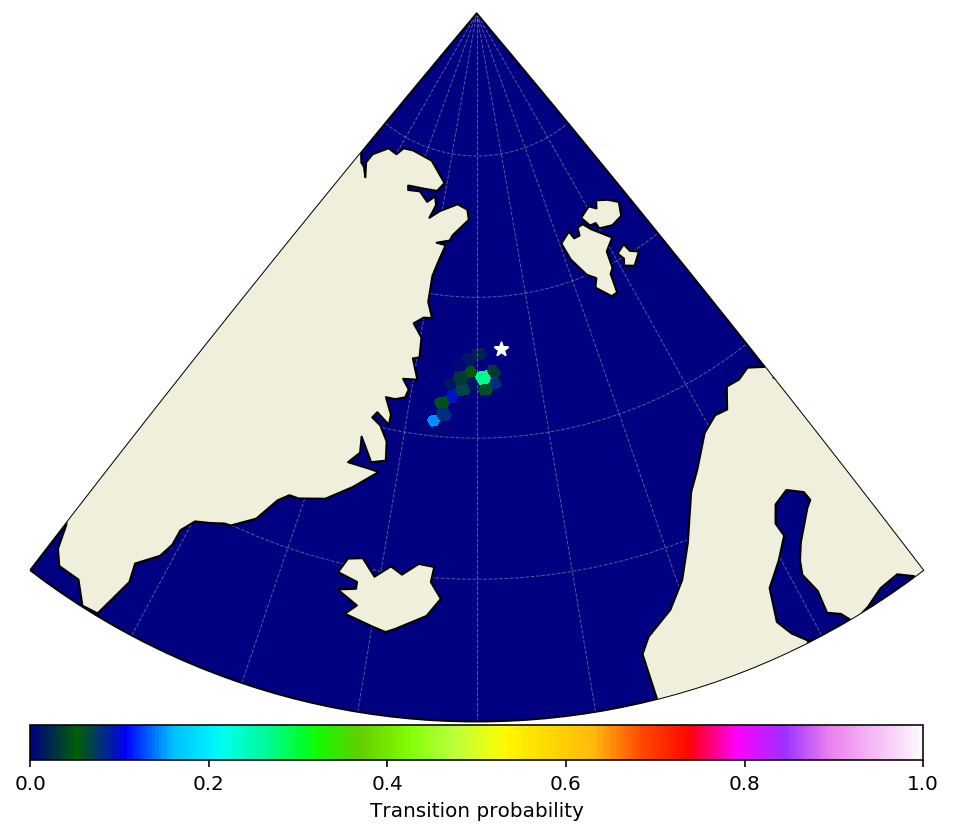

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
transitionProbabilityPoint(transMat_20180301.data, -5.73, 75.76)

In [31]:
symmetric = transMat_20180301.data + transMat_20180301.data.T - np.diagonal(transMat_20180301.data)*np.eye(transMat_20180301.data.shape[0])

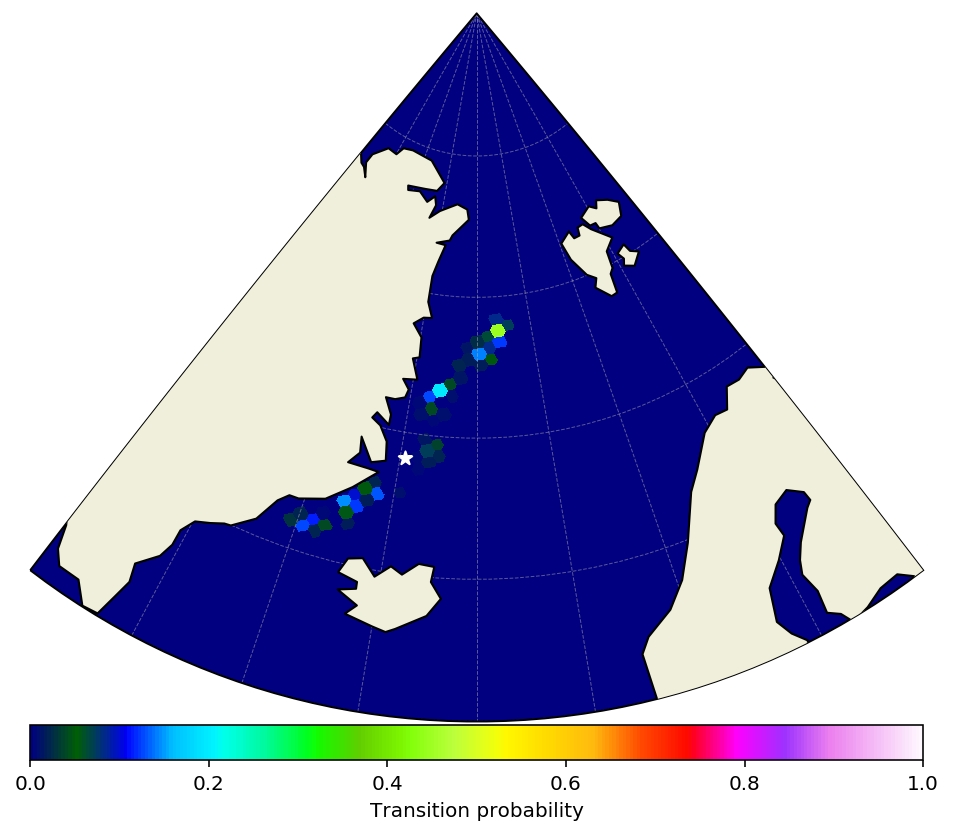

array([nan, nan, nan, ..., nan, nan, nan])

In [32]:
transitionProbabilityPoint(symmetric, -19.3, 70.9)

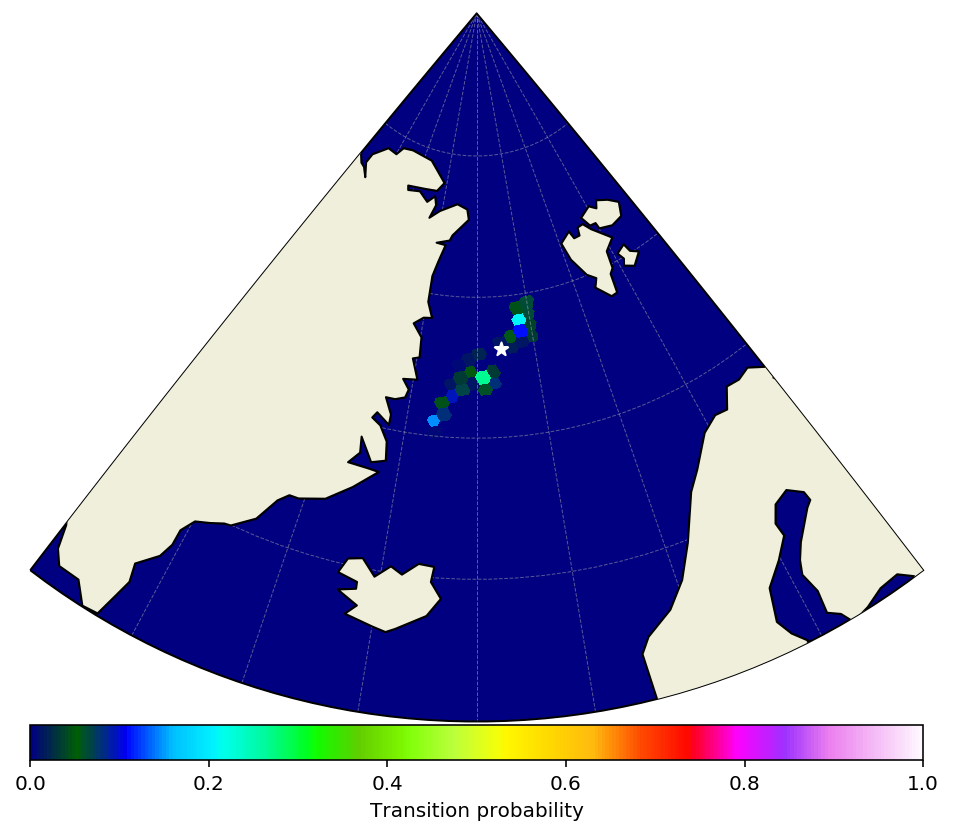

array([nan, nan, nan, ..., nan, nan, nan])

In [33]:
transitionProbabilityPoint(symmetric, -5.73, 75.76)

# Squared Counter

In [113]:
counterMatSparse = sparse.load_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")
matSquared = community.transMat(np.square(counterMatSparse.toarray()))


In [115]:
matSquared.save_counter(matdir + f"masked_counter_{runName}_squared_Cico7_subD30")
matSquared.save_network(netdir + f"masked_network_{runName}_squared_Cico7_subD30.net")

In [116]:
comName = runName + "_Cico7_subD30_squared_mt2"

In [118]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(matSquared);
myBins.calculate_global_coherence()
myBins.calculate_mixing(matSquared);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8228040398647576
Global Mixing Parameter 0.22455869801099307


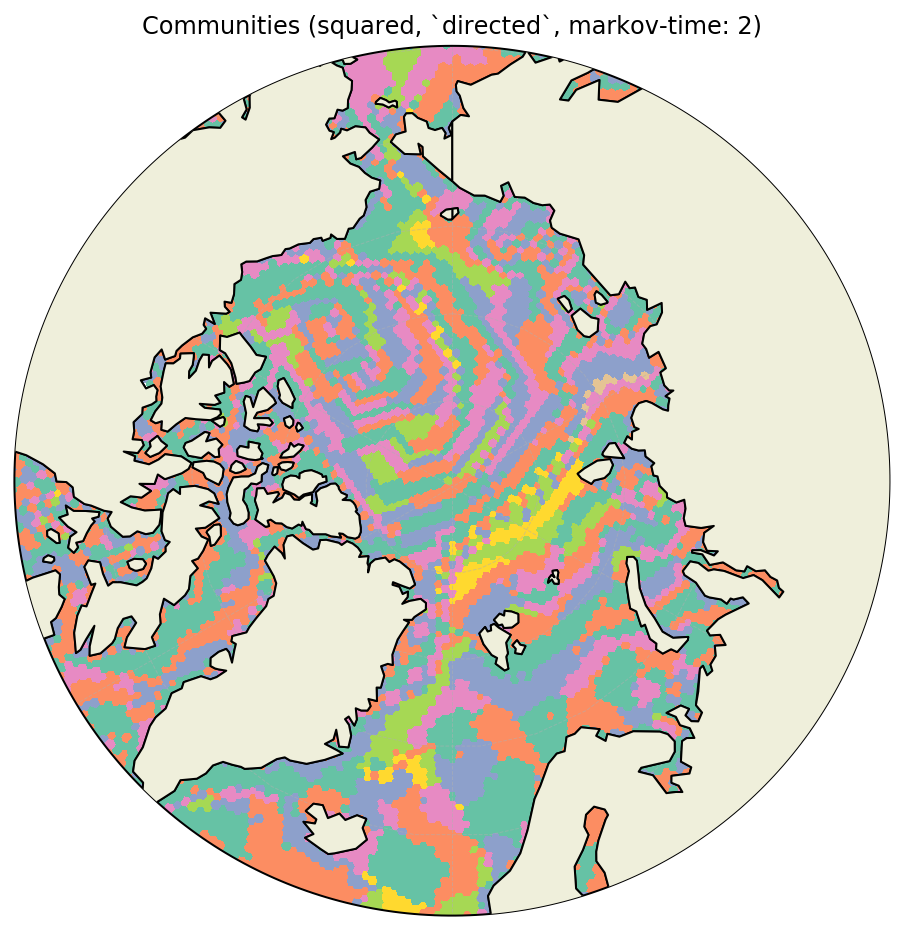

In [119]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (squared, `directed`, markov-time: 2)"
                                            )

# Teleportation probability

In [123]:
comName = runName + "_Cico7_subD30_mt2_p0.01"

In [126]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8014751167045745
Global Mixing Parameter 0.32233594177086217


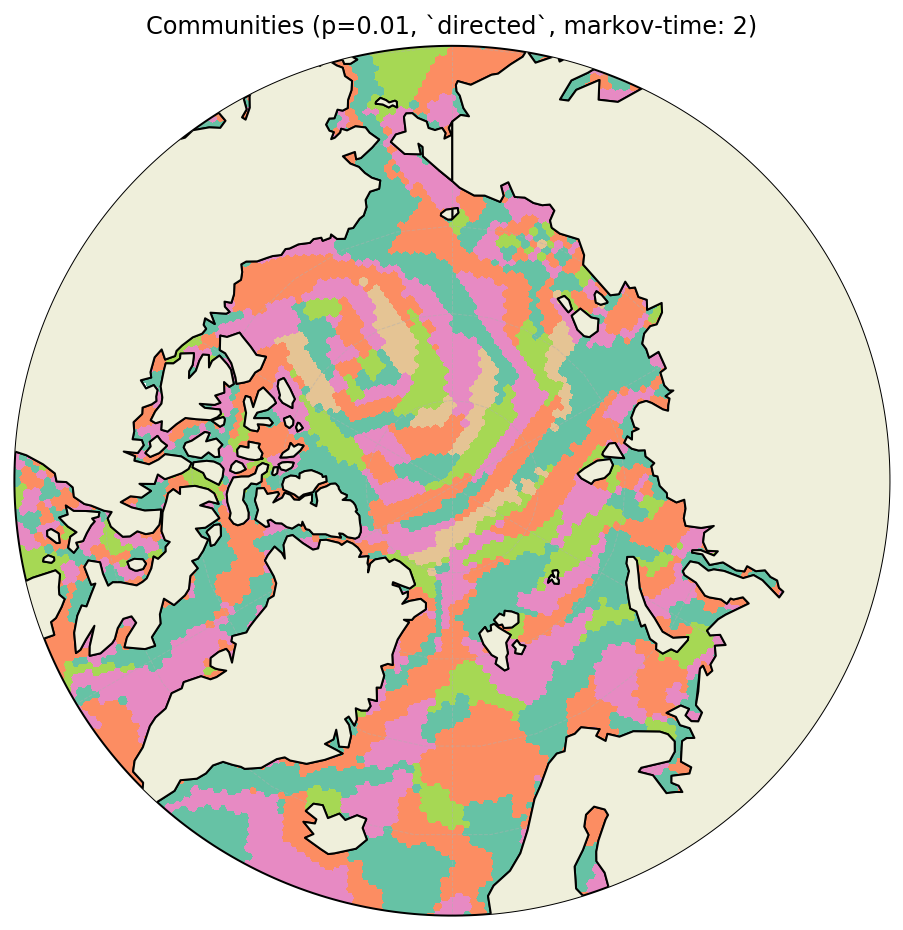

In [127]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (p=0.01, `directed`, markov-time: 2)"
                                            )

In [128]:
comName = runName + "_Cico7_subD30_mt2_p0"

In [129]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7726677204146044
Global Mixing Parameter 0.30956726743902147


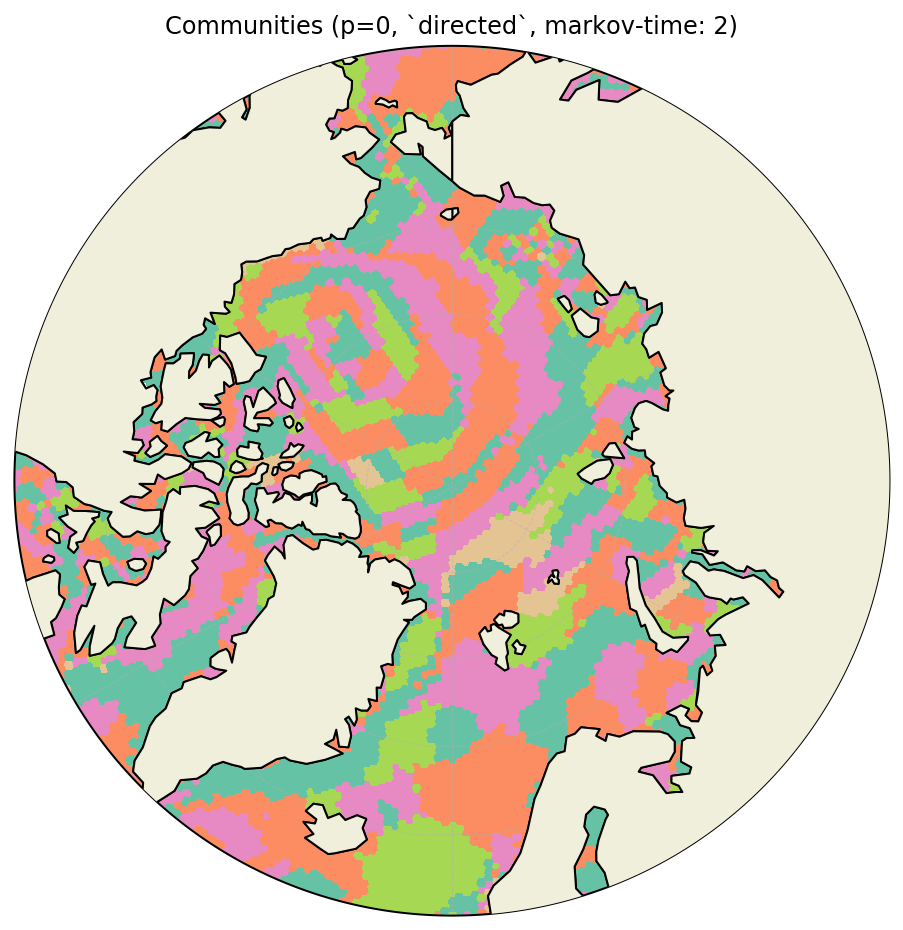

In [131]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (p=0, `directed`, markov-time: 2)"
                                            )